In [30]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [31]:
img_size = (48, 48)
batch_size = 32

# Ruta actualizada
dataDir = "dataset/train"

original_train_ds = tf.keras.utils.image_dataset_from_directory(
    dataDir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size
)

class_names = original_train_ds.class_names

# Normalización
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = original_train_ds.map(lambda x, y: (normalization_layer(x), y))

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataDir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


## Entrenamiento: 

In [41]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 🔄 Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

# 🧠 Modelo mejorado
model = models.Sequential([
    layers.Input(shape=(48, 48, 1)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.6),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(len(class_names), activation='softmax')
])

# ⚙️ Compilación
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ⏹️ EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# ⚖️ Class weights
y_train = []
for _, labels in train_ds.unbatch():
    y_train.append(labels.numpy())

y_train = np.array(y_train)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# 🏋️ Entrenamiento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)


Epoch 1/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 142s 188ms/step - accuracy: 0.1561 - loss: 3.1795 - val_accuracy: 0.1125 - val_loss: 169.5488
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 124s 173ms/step - accuracy: 0.1658 - loss: 2.1241 - val_accuracy: 0.1123 - val_loss: 437.1268
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 131s 182ms/step - accuracy: 0.1833 - loss: 1.9703 - val_accuracy: 0.1123 - val_loss: 356.5293
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 127s 177ms/step - accuracy: 0.1902 - loss: 1.9466 - val_accuracy: 0.1123 - val_loss: 306.3456
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 125s 174ms/step - accuracy: 0.2075 - loss: 1.9289 - val_accuracy: 0.1414 - val_loss: 163.0465
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 121s 168ms/step - accuracy: 0.2188 - loss: 1.9046 - val_accuracy: 0.1233 - val_loss: 303.6432
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 125s 174ms/step - accuracy: 0.2558 - loss: 1.8764 - val_accuracy: 0.1122 - val_loss: 146.6889
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 124s 172ms/step - accu

## Matriz de confusion: 

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predicciones
y_pred = np.argmax(model.predict(val_ds), axis=1)

# Etiquetas verdaderas
y_true = []
for _, labels in val_ds.unbatch():
    y_true.append(labels.numpy())
y_true = np.array(y_true)

# Reporte
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))



180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step
[[   0    0  214    0  530   19    2]
 [   0    0   15    0   74    4    1]
 [   0    0  226    0  550   29    5]
 [   0    0  289    0 1083   32    4]
 [   0    0  235    0  769   34    3]
 [   0    0  242    0  680   54    2]
 [   0    0  163    0  456    5   21]]
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       765
     disgust       0.00      0.00      0.00        94
        fear       0.16      0.28      0.21       810
       happy       0.00      0.00      0.00      1408
     neutral       0.19      0.74      0.30      1041
         sad       0.31      0.06      0.09       978
    surprise       0.55      0.03      0.06       645

    accuracy                           0.19      5741
   macro avg       0.17      0.16      0.09      5741
weighted avg       0.17      0.19      0.11      5741



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()


## Evaluacion del accuaracy

In [42]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/test",
    image_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size
)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

# Evaluar
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.2f}")


Found 7178 files belonging to 7 classes.
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.2412 - loss: 1.8228
Test accuracy: 0.24


## Grafica para ver la accuaracy del modelo:


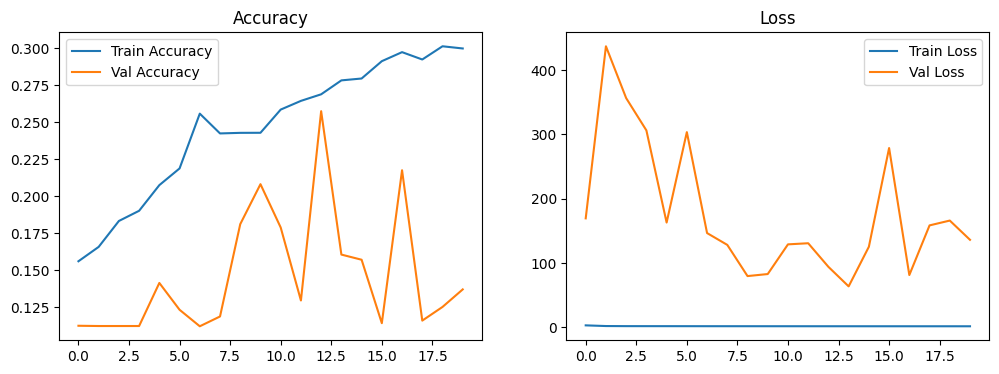

In [43]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


## Grafico para ver el desbalance:

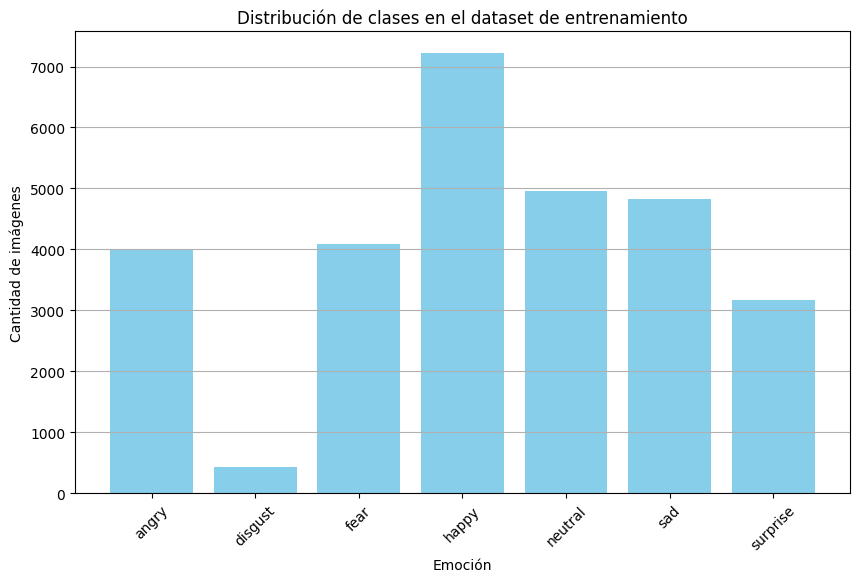

In [46]:
import matplotlib.pyplot as plt

# Conteo por clase
class_counts = {'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}

# Gráfico
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Distribución de clases en el dataset de entrenamiento")
plt.xlabel("Emoción")
plt.ylabel("Cantidad de imágenes")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


## Guardar el modelo

In [44]:
model.save("emotion_model.h5")